In [3]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.patches as mpatches
import numpy as np
from colour import Color
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

### Load wildfire database into datframe from SQL file

In [4]:
cnx = sqlite3.connect('FPA_FOD_20170508.sqlite')

df = pd.read_sql_query("SELECT * FROM Fires", cnx)

### Look at first 5 rows of the dataset

In [6]:
df.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


### Remove all fires that did not occur in Colorado

In [7]:
df = df.loc[df.STATE == "CO",:]

print(df.columns)

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')


### Look at FIRE_YEAR column

In [8]:
print(df.FIRE_YEAR)

47         2005
61         2005
62         2005
114        2005
205        2005
           ... 
1860039    2015
1860043    2015
1860044    2015
1860048    2015
1860054    2015
Name: FIRE_YEAR, Length: 34157, dtype: int64


### Remove unessecary coloumns

In [11]:
fires = df[["FOD_ID", "FIRE_YEAR", "FIRE_SIZE", "DISCOVERY_DOY", "DISCOVERY_TIME",
           "STAT_CAUSE_CODE", "STAT_CAUSE_DESCR", "CONT_DOY", "CONT_TIME", "FIRE_SIZE",
            "LATITUDE", "LONGITUDE", "STATE"]]
fires.head()

,FOD_ID,FIRE_YEAR,FIRE_SIZE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DOY,CONT_TIME,FIRE_SIZE,LATITUDE,LONGITUDE,STATE
47,48,2005,0.5,165,1300,1.0,Lightning,165.0,1530,0.5,39.292222,-105.183056,CO
61,62,2005,0.2,150,1100,1.0,Lightning,151.0,1218,0.2,38.913333,-105.983611,CO
62,63,2005,0.1,172,1241,4.0,Campfire,172.0,1506,0.1,39.100278,-106.367500,CO
114,117,2005,80.0,188,1907,1.0,Lightning,188.0,2130,80.0,37.345000,-102.805833,CO
205,209,2005,2.5,164,1428,9.0,Miscellaneous,164.0,1736,2.5,38.891111,-105.431944,CO


### Create boxplot showing the number of fire occurances throughout the years in the dataset. The dataset includes data from 1992-2015

C:\Users\Paxton\AppData\Local\Temp\ipykernel_147168\1711086382.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fires["Ones"] = 1


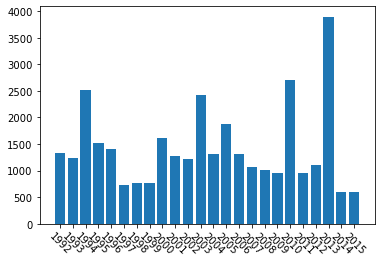

In [38]:
fires["Ones"] = 1

fireHistData = fires.groupby('FIRE_YEAR').sum()["Ones"]

xticks = list(range(1992,2015 + 1))
plt.bar(xticks, fireHistData)
plt.xticks(xticks)
plt.xticks(rotation=-45)

plt.show()


### Read in Colorado shape file and print it out. This shape file includes the boundary lines for the counties

In [13]:
#Data Visualization

coMap = gpd.read_file("Colorado_County_Boundaries\\Colorado_County_Boundaries.shp")

<AxesSubplot:>

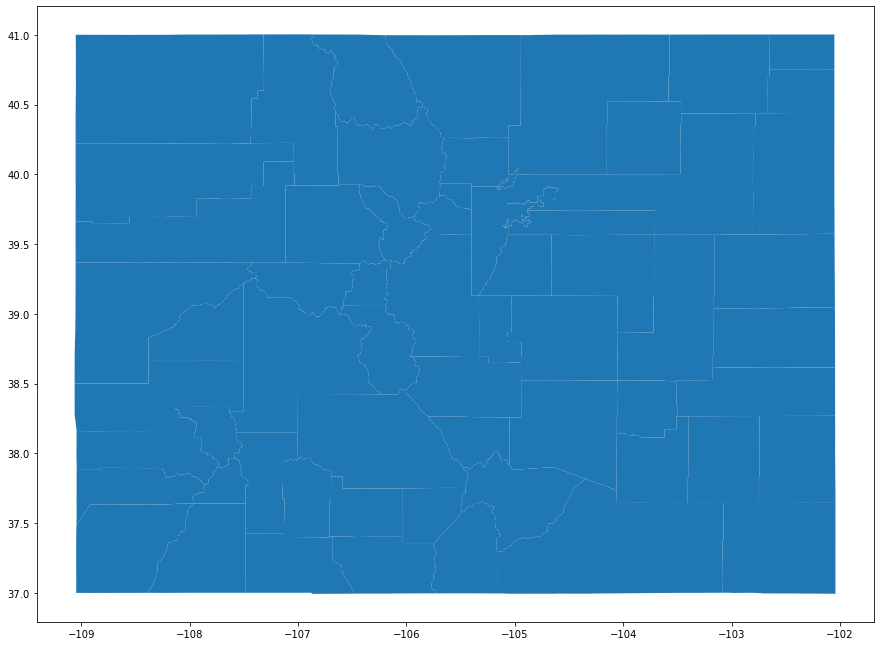

In [39]:
fig, ax = plt.subplots(figsize = (15,15))
coMap.plot(ax = ax)

### Overlay longitude and latitude coordinates of fires on top of Colorado map

<AxesSubplot:>

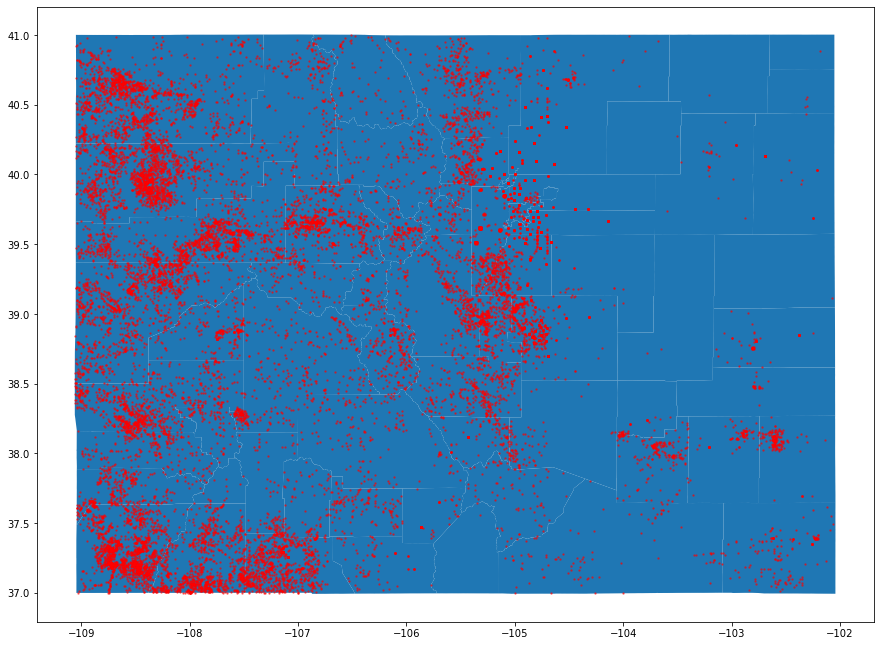

In [40]:
trainingFires = fires.loc[(fires.FIRE_YEAR >= 2000) & (fires.FIRE_YEAR <= 2012),:]

fig2, ax2 = plt.subplots(figsize = (15,15))
crs = "EPSG:4326"
geometry = [Point(xy) for xy in zip(trainingFires.LONGITUDE, trainingFires.LATITUDE)]

geo_df = gpd.GeoDataFrame(trainingFires, crs = crs, geometry = geometry)

markerSize = trainingFires.FIRE_SIZE.astype(int)
coMap.plot(ax = ax2)
geo_df.plot(ax = ax2, markersize = 2, color = 'red', alpha = .5)


### Find bounds for visualizations by finding the max and min longitude and latitude coordinates. These were adjusted slightly for visualization purposes so that everything fit nice

In [41]:
maxLat = trainingFires.loc[trainingFires['LATITUDE'].idxmax()]['LATITUDE'] + .01
minLat = trainingFires.loc[trainingFires['LATITUDE'].idxmin()]['LATITUDE']
maxLon = trainingFires.loc[trainingFires['LONGITUDE'].idxmax()]['LONGITUDE'] + .03
minLon = trainingFires.loc[trainingFires['LONGITUDE'].idxmin()]['LONGITUDE']

print(maxLat)
print(minLat)
print(maxLon)
print(minLon)



41.0083
36.99853
-102.03746072999999
-109.0618


### Since we want to approximate the underlying probability distribution of where fires start, it is important to create a heatmap of where fires are occuring. Colorado is segemented into a certain number of rectangles. We then count the number of fires in each rectangle region and assign a color to the region based on the number of fires

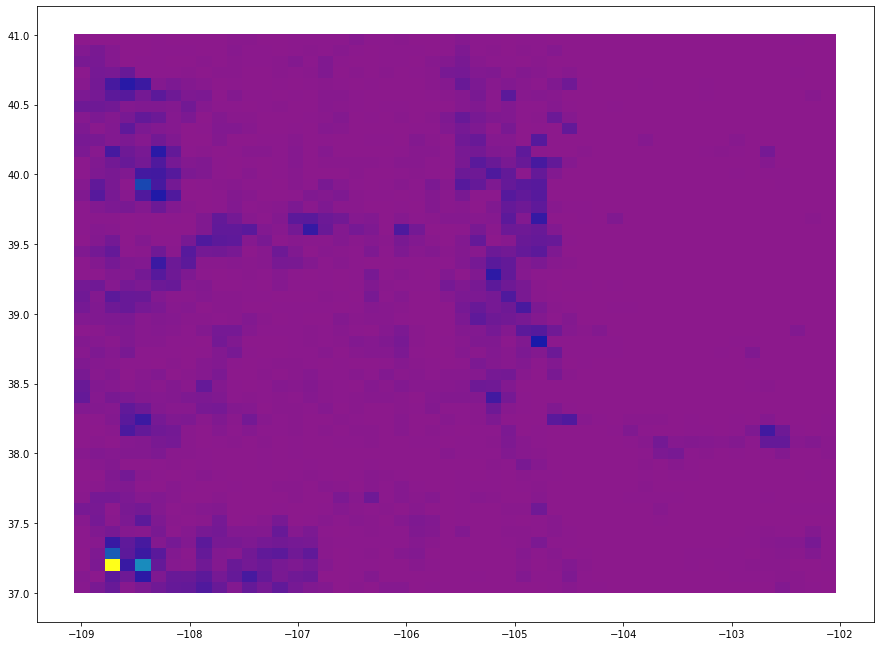

In [50]:
fig, ax = plt.subplots(figsize = (15,15))

numRectWide = 50
numRectTall = 50
w = (maxLon - minLon) / numRectWide
h = (maxLat - minLat) / numRectTall

bottomLefts = np.zeros([numRectTall, numRectWide, 2])
points = np.zeros([numRectTall * numRectWide, 2])
GlobalBottomLeft = [minLat, minLon]

for r in range(numRectTall):
    for c in range(numRectWide):
        bottomLefts[r,c,0] = GlobalBottomLeft[0] + h * r
        bottomLefts[r,c,1] = GlobalBottomLeft[1] + w * c
        points[numRectTall * r + c][1] = GlobalBottomLeft[1] + w * c
        points[numRectTall * r + c][0] = GlobalBottomLeft[0] + h * r

        
coMap.plot(ax = ax, color = "white")

pointDensities = np.zeros(numRectTall * numRectWide)
i = 0

for point in points:
    #print(point)
    firesInRegion = fires.loc[(fires.LATITUDE > point[0]) & (fires.LATITUDE <= (point[0] + h)) & (fires.LONGITUDE > point[1]) & (fires.LONGITUDE <= (point[1] + h)),:]
    pointDensities[i] = len(firesInRegion['FOD_ID'])
    i = i + 1

maxDens = max(pointDensities)

numColors = 200

pointDensities = numColors * pointDensities / maxDens

yellow = Color("purple")
colors = list(yellow.range_to(Color("yellow"),numColors + 1))
colors = [c.hex for c in colors]

i = 0
for point in points:
    facecolor = colors[int(round(pointDensities[i]))]
    rect=mpatches.Rectangle((point[1],point[0]),w,h, 
                        alpha=0.9,
                        facecolor=facecolor)
    plt.gca().add_patch(rect)
    i = i + 1

#geo_df.plot(ax = ax, markersize = 2, color = 'red', alpha = .5)

### Here we train our model. The underlying probability distribution was approximated using kernel density estimation. The longitude and latitude values from the training set are extracted. Models are tested by GridSearchCV and the optimal bandwidth parameter is found. The probabiliy distribution is then printed out and the training data points are overlayed on top

C:\Users\Paxton\AppData\Local\Temp\ipykernel_147168\2482775943.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx, yy, zs)


<AxesSubplot:>

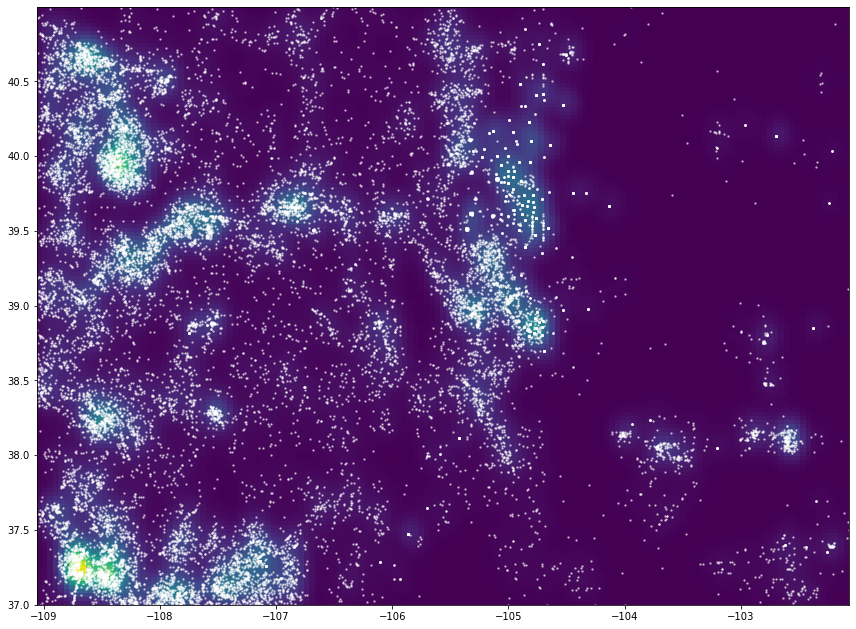

In [45]:
x = trainingFires.LONGITUDE
y = trainingFires.LATITUDE

longLatCoordinates = np.vstack([x, y]).T

#kde = KernelDensity(bandwidth=.2, kernel='gaussian', metric = 'euclidean')
kde = GridSearchCV(KernelDensity(kernel='gaussian', metric = 'euclidean'),
                    {'bandwidth': np.linspace(0.005, .1, 5)},
                    cv=20)

kde.fit(longLatCoordinates)

xbins = 150
ybins = 150

xx, yy = np.meshgrid(np.linspace(x.min(),x.max(),xbins), 
                 np.linspace(y.min(),y.max(),ybins))
xy_sample = np.vstack([xx.ravel(), yy.ravel()]).T

zs = np.exp(kde.score_samples(xy_sample))    
zs = np.reshape(zs, xx.shape)


fig, ax = plt.subplots(figsize = (15,11))
ax.pcolormesh(xx, yy, zs)
geo_df.plot(ax = ax, markersize = 2, color = 'white', alpha = .5)

### Print out optimal bandwidth

In [46]:
kde.best_params_

{'bandwidth': 0.07625000000000001}

### Print out underlying probability distribution without training set overlayed on top

C:\Users\Paxton\AppData\Local\Temp\ipykernel_147168\332603175.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx, yy, zs)


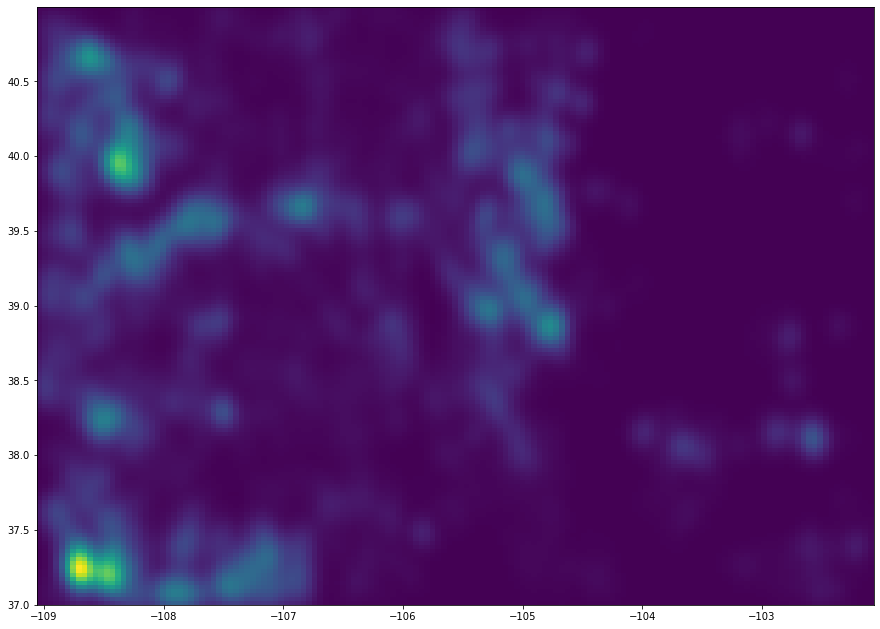

In [47]:
fig, ax = plt.subplots(figsize = (15,11))
ax.pcolormesh(xx, yy, zs)

### Overlay the future years to evaluate the performance of the model

C:\Users\Paxton\AppData\Local\Temp\ipykernel_147168\1552833145.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(xx, yy, zs)


<AxesSubplot:>

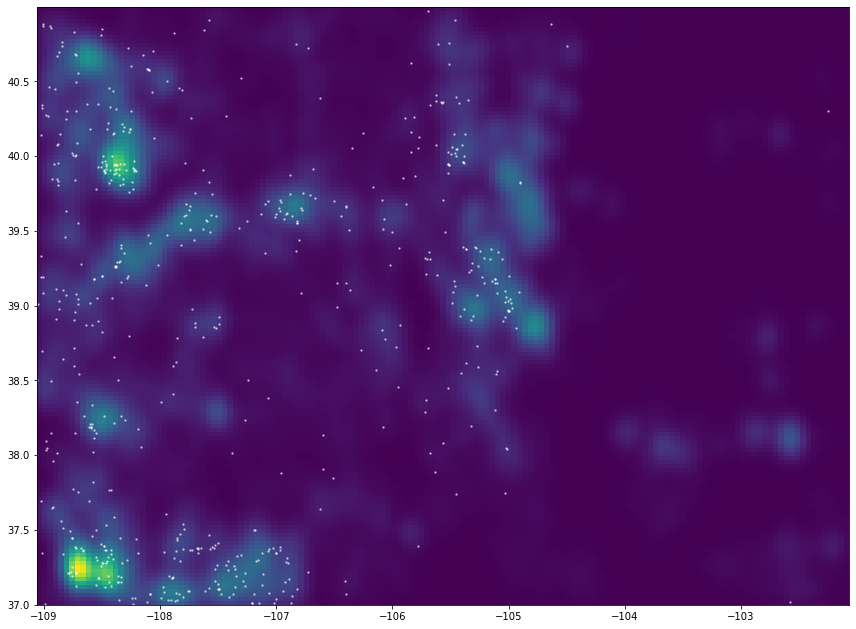

In [48]:
fig, ax = plt.subplots(figsize = (15,11))
testingFires = fires.loc[(fires.FIRE_YEAR >= 2014) & (fires.FIRE_YEAR <= 2014),:]

crs = "EPSG:4326"
geometryTesting = [Point(xy) for xy in zip(testingFires.LONGITUDE, testingFires.LATITUDE)]
geo_df_test = gpd.GeoDataFrame(testingFires, crs = crs, geometry = geometryTesting)

geo_df_test.plot(ax = ax, markersize = 2, color = 'white', alpha = .5)

ax.pcolormesh(xx, yy, zs)
geo_df_test.plot(ax = ax, markersize = 2, color = 'white', alpha = .5)